<h1>Проект для «Викишоп»<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-описание-данных" data-toc-modified-id="Загрузка-и-описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и описание данных</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-загрузке-данных" data-toc-modified-id="Вывод-по-загрузке-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод по загрузке данных</a></span></li></ul></li><li><span><a href="#Лемматизация-текста-и-удаление-ненужных-символов" data-toc-modified-id="Лемматизация-текста-и-удаление-ненужных-символов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Лемматизация текста и удаление ненужных символов</a></span></li><li><span><a href="#Разбивка-на-тренировочную-и-тестовую-выборки,-подготовка-данных" data-toc-modified-id="Разбивка-на-тренировочную-и-тестовую-выборки,-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разбивка на тренировочную и тестовую выборки, подготовка данных</a></span></li><li><span><a href="#Вывод-по-подготовке-данных" data-toc-modified-id="Вывод-по-подготовке-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод по подготовке данных</a></span></li><li><span><a href="#Подготовка-и-обучение-моделей" data-toc-modified-id="Подготовка-и-обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовка и обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Предсказание-лучшей-модели" data-toc-modified-id="Предсказание-лучшей-модели-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Предсказание лучшей модели</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

# Инструкция для проекта

Решить задачу можно как с помощью BERT, так и без этой нейронки. Если хотите попробовать BERT —
Выполните проект локально. В тренажере тетрадь Jupyter ограничена 4 ГБ оперативной памяти — для проекта с BERT этого может не хватить.

Упомяните BERT в заголовке проекта в первой ячейке:

Выполнить проект без BERT можно локально или в нашем тренажёре.
В любом случае алгоритм решения выглядит так:
Загрузите и подготовьте данные.
Обучите разные модели.
Сделайте выводы.

In [178]:
import pandas as pd
import numpy as np
import nltk
import re
import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from pymystem3 import Mystem
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from tqdm.notebook import tqdm

In [179]:
RANDOM_STATE = 42

### Загрузка и описание данных

Данные находятся в файле `toxic_comments.csv`

Текст комментария содержится в столбце **text**

Целевой признак - **toxic**

In [180]:
file_local = '/Users/alexfil/Desktop/Practicum/Проекты/ml_texts/toxic_comments.csv'
file_ya = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [181]:
try:
    df = pd.read_csv(file_local) 
except:
    df = pd.read_csv(file_ya)

In [182]:
df.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [183]:
df.shape

(159292, 3)

Удалим неизвестный столбец:

In [184]:
df = df.drop('Unnamed: 0', axis = 1)
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [185]:
df.shape

(159292, 2)

In [186]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [187]:
df.duplicated().sum()

0

Проверим баланс классов:

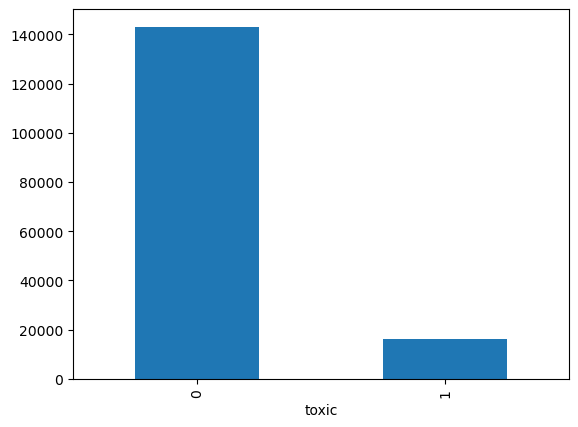

In [188]:
df['toxic'].value_counts().plot(kind='bar');

#### Вывод по загрузке данных

1. Загружен датасет размерностью 159292 строки и 3 столбца
2. Произведено удаление неизвестного столбца 'Unnamed: 0'
3. Пропущенных значений и дубликатов не выявленно
4. Работать будем с итоговым датасетом размерностью 159292 строки и 2 столбца
5. Целевой признак toxic с не сбалансированными классами и многократным перевесом в пользу класса 0. Этот файкт возможно учесть при делении датафрейма на обучающие и тестовые выборки, но в данный момент по условиям задачи не требуется.

### Лемматизация текста и удаление ненужных символов

In [189]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package wordnet to /Users/alexfil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alexfil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/alexfil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alexfil/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [190]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemm_and_clear(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in tagged_tokens]
    lemmatized_text = ' '.join(lemmas)
    cleaned_text = re.sub(r'[^a-zA-Z\' ]', '', lemmatized_text)
    cleaned_text = cleaned_text.replace('\n', '')
    
    return cleaned_text

In [191]:
tqdm.pandas()
df['lemm_text'] = df['text'].progress_apply(lemm_and_clear)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [192]:
df.head(5)

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d'aww he match this background colour i 'm se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i 'm really not try to edit war it '...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i ca n't make any real suggestion on imp...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember ...


In [193]:
df = df.drop(['text'], axis=1)
df.head(5)

,toxic,lemm_text
0,0,explanation why the edits make under my userna...
1,0,d'aww he match this background colour i 'm se...
2,0,hey man i 'm really not try to edit war it '...
3,0,more i ca n't make any real suggestion on imp...
4,0,you sir be my hero any chance you remember ...


Проверим на наличие дубликатов после лемматизации:

In [194]:
df.duplicated().sum()

627

In [195]:
df = df.drop_duplicates()

In [196]:
df.duplicated().sum()

0

### Разбивка на тренировочную и тестовую выборки, подготовка данных

In [197]:
X = df.drop('toxic', axis = 1)
y = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.4,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [198]:
X_train.shape

(95199, 1)

In [199]:
X_test.shape

(63466, 1)

Трансформацию текстов в векторы при попомщи TF-IDF будем проводить в пайплайне

In [200]:
pipeline = Pipeline(
    [
        ('vect', TfidfVectorizer(stop_words=stopwords)),
        ('clf', LogisticRegression(solver='liblinear', random_state = RANDOM_STATE)),
    ]
)

In [201]:
pipeline

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

### Вывод по подготовке данных

1. Выполнены лемматизация текста и удаление ненужных символов
2. После лемматизации выявлено и удалено 1294 дубликата
3. Выполнена разбивка на тренировочную выборки с разметностью test_size=0.4
4. Трансформация текстов в векторы при попомщи TF-IDF будет производиться в пайплайне

### Подготовка и обучение моделей

In [202]:
param_grid = [
    {
        'clf': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'clf__max_depth': range(2, 5)
    },
    {
        'clf': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        )],
        'clf__penalty': ('l1', 'l2'),
        'clf__C': list(range(5, 15, 1))
    }
]

In [203]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    scoring='f1',
    n_iter=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    cv=5,
    error_score='raise'
)

In [204]:
random_search.fit(X_train['lemm_text'], y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('vect',
                                              TfidfVectorizer(stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'ain',
                                                                          'all',
                                                                          'am',
                                                                          'an',
                                                                          'and',
                                                                          'any',
                                                                          'are',
                                                                          'aren',
                                                                          "aren't",
                                                                          'as',
                                                                          'at',
                                                                          'be',
                                                                          'because',
                                                                          'been',
                                                                          'before',
                                                                          'being',
                                                                          'below',
                                                                          'between',
                                                                          'both',
                                                                          'but',
                                                                          'by',
                                                                          'can',
                                                                          'couldn',
                                                                          "couldn't", ...})),
                                             ('clf',
                                              LogisticRegression(random_state=42,
                                                                 solver='liblinear'))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions=[{'clf': [DecisionTreeClassifier(random_state=42)],
                                         'clf__max_depth': range(2, 5)},
                                        {'clf': [LogisticRegression(C=8,
                                                                    penalty='l1',
                                                                    random_state=42,
                                                                    solver='liblinear')],
                                         'clf__C': [5, 6, 7, 8, 9, 10, 11, 12,
                                                    13, 14],
                                         'clf__penalty': ('l1', 'l2')}],
                   random_state=42, scoring='f1')

In [205]:
print('Best parameters:', random_search.best_params_)
print('Best F1 score:', random_search.best_score_)

Best parameters: {'clf__penalty': 'l1', 'clf__C': 8, 'clf': LogisticRegression(C=8, penalty='l1', random_state=42, solver='liblinear')}
Best F1 score: 0.7623672701317373


**Вывод:** Лучшей моделью на кросс-валидации является LogisticRegression с параметрами 'penalty': 'l1', 'C': 8. Метрика F1 равна 0.76, что соответствет условию задачи.

#### Предсказание лучшей модели

In [206]:
preds = random_search.predict(X_test['lemm_text'])
print('F1 score:', f1_score(y_test, preds))

F1 score: 0.7726050420168068


Метрика лучшей модели на тестовой выборке равна 0.77, что полностью соответствует условиям задачи

###  Общий вывод

1. Заказчиком предоставлен датасет размерностью 159292 строки и 3 столбца

2. Произведено удаление неизвестного столбца 'Unnamed: 0'

3. Пропущенных значений и дубликатов не выявленно

4. Работа выполнена с итоговым датасетом размерностью 159292 строки и 2 столбца

5. Выполнены лемматизация текста и удаление ненужных символов

6. После лемматизации выявлено и удалено 1294 дубликата

7. Выполнена разбивка на тренировочную выборки с разметностью test_size=0.4

8. Выполнена трансформация текстов в векторы при попомщи TF-IDF с использованием пайплайна

9. Выполнено обучение двух моделей LogisticRegression, DecisionTreeClassifier

10. Лучшей моделью на тренировочной выборке является LogisticRegression с параметрами 'penalty': 'l1', 'C': 8. Метрика F1 равна 0.76, что соответствет условию задачи.

11. Метрика лучшей модели на тестовой выборке равна 0.77, что полностью соответствует условиям задачи